In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from tifffile import imread
import copy
np.set_printoptions(precision=3, suppress=True)  # Print as 0.001 instead of 9.876e-4
torch.set_printoptions(precision=3, sci_mode=False)

In [3]:
#I copied a bunch of this stuff from lab 5
def plot_matrix_grid(V, cmap='bwr'):
    """
    Given an array V containing stacked matrices, plots them in a grid layout.
    V should have shape (K,M,N) where V[k] is a matrix of shape (M,N).
    The default cmap is "bwr" (blue-white-red) but can also be "gray".
    """
    if isinstance(V, torch.Tensor):
        V = V.detach().numpy()
    assert V.ndim == 3, "Expected V to have 3 dimensions, not %d" % V.ndim
    k, m, n = V.shape
    ncol = 8                                     # At most 8 columns
    nrow = min(4, (k + ncol - 1) // ncol)        # At most 4 rows
    V = V[:nrow*ncol]                            # Focus on just the matrices we'll actually plot
    figsize = (2*ncol, max(1, 2*nrow*(m/n)))     # Guess a good figure shape based on ncol, nrow
    fig, axes = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=figsize)
    vmax = np.percentile(np.abs(V), [99.9])      # Show the main range of values, between 0.1%-99.9%
    for v, ax in zip(V, axes.flat):
        img = ax.matshow(v, vmin=-vmax, vmax=vmax, cmap=plt.get_cmap(cmap))
        ax.set_xticks([])
        ax.set_yticks([])
    for ax in axes.flat[len(V):]:
        ax.set_axis_off()
    fig.colorbar(img, cax=fig.add_axes([0.92, 0.25, 0.01, .5]))   # Add a colorbar on the right

In [4]:
def load_mnist_for_convnet(filename):
    """
    Loads the MNIST data from a Numpy NPZ file and returns two PyTorch tensors:
    X: a float tensor with shape (N,1,28,28) where N is the number of images in the file
    y: an int64 tensor with shape (N,) containing the class targets for the images.
    The pixels values are scaled to be in range [0,1] where 0 is black and 1 is white.
    """
    # Your code here. Aim for 7-10 lines.
    with np.load(filename) as data:

        X = data['X'].astype(np.float32)
        y = data['y'].astype(np.int64)
    X /= 255
    X = X.reshape(-1, 1, 28, 28)  # (N,1,28,28)
    return torch.from_numpy(X), torch.from_numpy(y)

# It should be used like this:
# X_trn, y_trn = load_mnist_for_convnet("mnist_train.npz")
# X_tst, y_tst = load_mnist_for_convnet("mnist_test.npz")

In [5]:
# My code starts here

# Open a file in write mode to save image data to
dataFile = open("imageData.npz", "w")

testArray = np.array([[0, 1], [1, 0]])
# Double the length and width of the array 4 times.
for i in range(4):
    testArray = np.concatenate((testArray, np.copy(testArray)), axis=0)
    testArray = np.concatenate((testArray, np.copy(testArray)), axis=1)

print(testArray)
print(testArray.shape)

# NOTES WHEN SAVING:
# - the .npz has 2 "files": X and y.
# - Save it like this:
#   - Make the X array
#   - Make the y array (array of integers representing each class)
#   - np.savez(dataFile, X=X, y=y)

# Close the file now that we're done with it (for now)
dataFile.close()



[[0 1 0 ... 1 0 1]
 [1 0 1 ... 0 1 0]
 [0 1 0 ... 1 0 1]
 ...
 [1 0 1 ... 0 1 0]
 [0 1 0 ... 1 0 1]
 [1 0 1 ... 0 1 0]]
(32, 32)


In [6]:
def getTifImages(path, currentClass):
    # Images are 224 by 244 pixels with 3 RGB channels each.

    counter = 0
    newArray = True
    arrayIndex = 0
    arrays = []

    fileList = os.listdir(path + "\\" + currentClass)

    for filename in fileList:

        f = os.path.join(path, currentClass, filename)
        
        if os.path.isfile(f) and filename != ".DS_Store":
            if counter % 2 == 0:
                newArray = True

            if newArray:
                arrays.append(imread(f).reshape((1, 224, 224, 3)).astype(np.uint8))
                arrayIndex = len(arrays) - 1
                newArray = False
            else:
                arrays[arrayIndex] = np.concatenate((arrays[arrayIndex], imread(f).reshape((1, 224, 224, 3)).astype(np.uint8)), axis=0)

            counter = counter + 1

    print(counter)

    while len(arrays) > 1:
        lastArrays = arrays
        arrays = []
        arrayIndex = 0

        counter = 0
        for nparr in lastArrays:
            if counter % 2 == 0:
                newArray = True

            if newArray:
                arrays.append(nparr)
                arrayIndex = len(arrays) - 1
                newArray = False
            else:
                arrays[arrayIndex] = np.concatenate((arrays[arrayIndex], nparr), axis=0)

            counter = counter + 1

        # print(arrays[0].shape)

    # Finally, what all this was for - the image data with shape (2000, 224, 224, 3)
    # - 2000 images, 244 by 244 pixels, 3 color channels
    return arrays[0]

class1Test_X = getTifImages("images\\Dataset 1\\Dataset 1\\Colorectal Cancer", "STR")
class2Test_X = getTifImages("images\\Dataset 1\\Dataset 1\\Colorectal Cancer", "MUS")
class3Test_X = getTifImages("images\\Dataset 1\\Dataset 1\\Colorectal Cancer", "NORM")

2000
2000
2000


(2000, 224, 224, 3)
(2000, 224, 224, 3)
(2000, 224, 224, 3)
(2000, 3, 224, 224)
(2000, 3, 224, 224)
(2000, 3, 224, 224)


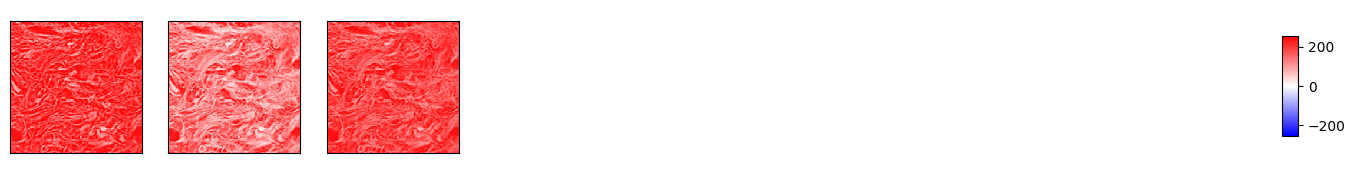

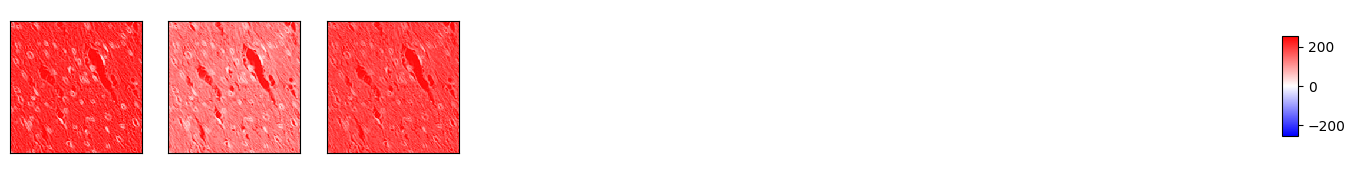

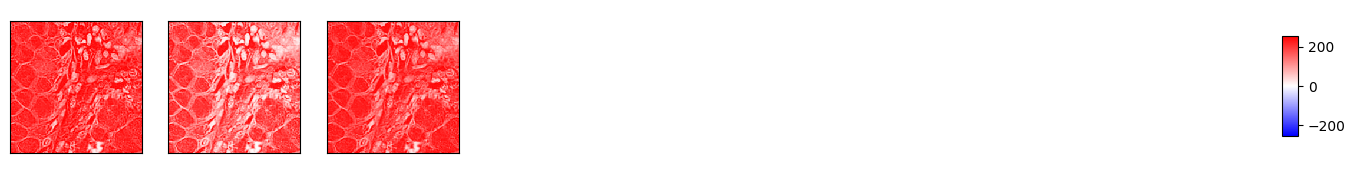

In [7]:
print(class1Test_X.shape)
print(class2Test_X.shape)
print(class3Test_X.shape)

c1_X = np.swapaxes(class1Test_X, 1, 3)
c2_X = np.swapaxes(class2Test_X, 1, 3)
c3_X = np.swapaxes(class3Test_X, 1, 3)

print(c1_X.shape)
print(c2_X.shape)
print(c3_X.shape)

plot_matrix_grid(c1_X[0])
plot_matrix_grid(c2_X[0])
plot_matrix_grid(c3_X[0])

In [8]:
# Set up the y data
# CLASS LEGEND: STR = 0, MUS = 1, NORM = 2
c1_y = np.zeros((2000,))
c2_y = np.zeros((2000,)) + 1
c3_y = np.zeros((2000,)) + 2

print(c1_y[0])
print(c2_y[0])
print(c3_y[0])

# Shuffle all the data
all_X = np.concatenate((c1_X, c2_X), axis = 0)
print(all_X.shape)
all_X = np.concatenate((all_X, c3_X), axis = 0)
print(all_X.shape)
all_y = np.concatenate((c1_y, c2_y), axis = 0)
print(all_y.shape)
all_y = np.concatenate((all_y, c3_y), axis = 0)
print(all_y.shape)

p = np.random.permutation(all_X.shape[0])
all_X = all_X[p]
all_y = all_y[p]
print(all_X.shape)
print(all_y.shape)

0.0
1.0
2.0
(4000, 3, 224, 224)
(6000, 3, 224, 224)
(4000,)
(6000,)
(6000, 3, 224, 224)
(6000,)


MUS
STR
NORM


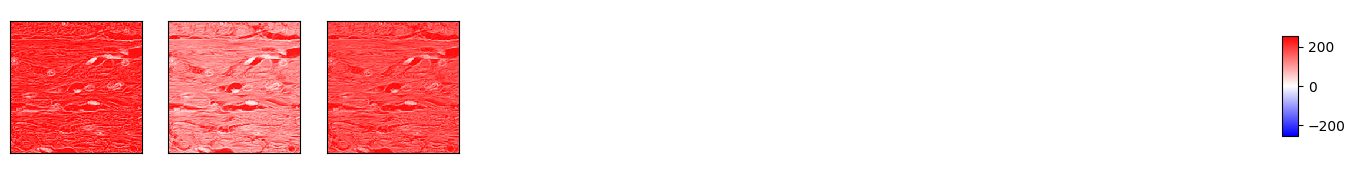

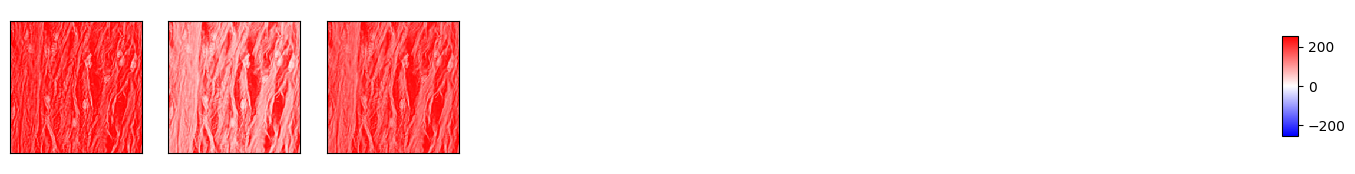

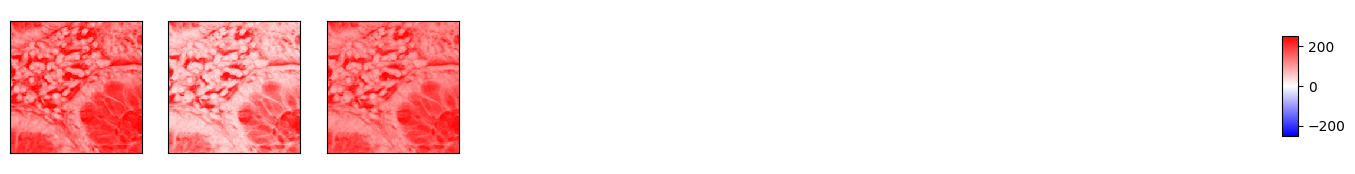

In [9]:
def printClass(num):
    if num == 0: print("STR")
    if num == 1: print("MUS")
    if num == 2: print("NORM")

printClass(all_y[0])
plot_matrix_grid(all_X[0])
printClass(all_y[1])
plot_matrix_grid(all_X[1])
printClass(all_y[2])
plot_matrix_grid(all_X[2])

In [ ]:
# Train & Test groups

train_weight = 7
test_weight = 3
total_weight = train_weight + test_weight

total_rows = all_X.shape[0]
train_rows = round(total_rows * (train_weight / total_weight) - 0.5)
test_rows = round(total_rows * (test_weight / total_weight) - 0.5)

trn_X = all_X[0:train_rows]
tst_X = all_X[train_rows:]
trn_y = all_y[0:train_rows]
tst_y = all_y[train_rows:]

print(trn_X[0:5].astype(np.uint8))

[[[[ -87  -75  -49 ...  -62  -28  -36]
   [ -89 -102 -119 ...  -27  -11   -1]
   [  -1   -1  -41 ... -108  -53  -12]
   ...
   [ -83  -61  -27 ...  -43  -80 -109]
   [ -25  -14   -1 ...  -87  -46  -30]
   [ -11   -1   -4 ...  -93  -63   -4]]

  [[  85   94  116 ...  115 -118  127]
   [  86   77   72 ...  126 -105  -90]
   [ -98 -105  126 ...   90  125 -110]
   ...
   [  97  119 -111 ...  127  101   74]
   [-107  -95  -79 ...  107  113  116]
   [ -97  -78  -83 ...   84  106 -111]]

  [[-108  -99  -69 ...  -84  -61  -69]
   [-106 -116 -119 ...  -67  -47  -32]
   [ -32  -42  -73 ... -103  -64  -43]
   ...
   [-103  -76  -48 ...  -78  -96 -125]
   [ -56  -39  -21 ...  -95  -67  -81]
   [ -40  -34  -39 ... -111  -84  -45]]]


 [[[ -22  -23  -37 ...  -49  -74  -86]
   [ -28  -23  -40 ...  -53  -82  -99]
   [ -35  -28  -40 ...  -55  -80  -98]
   ...
   [ -73 -102 -111 ...  -63 -103  -76]
   [ -76  -98 -105 ...  -71 -101  -66]
   [ -71  -91  -97 ...  -79  -97  -57]]

  [[-100  -91  -95 ...  12

In [11]:
np.savez("Dataset1Data.npz", trn_X=trn_X, trn_y=trn_y, tst_X=tst_X, tst_y=tst_y)

TO-DO:
- set up the y arrays
    - DONE
- shuffle the data
    - DONE
- split into train & test groups
    - DONE
- save as .npz files
    - DONE
- Write progress report
- train a cnn machine
- more stuff later...